In [1]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams["font.size"] = 14
import glob
import sdf
import tqdm
from epoch_viz.viz import EpochViz

In [2]:
DATA_DIR ="SG/p_4/"

In [3]:
c = 3*1e8
e = 1.6*1e-19
m=9.1*1e-31
lambda0 = 1e-6
tau=lambda0/c
las_time = 20*tau
omega0 = 2*np.pi*c/lambda0
Er = m * omega0 * c / e
nx = 16000
t_end =40*tau
dt_snapshot = 0.08e-15
x_min = -20*lambda0
x_max = 20*lambda0
factor =4
epsilon = 8.85418782e-12
nc = epsilon*m*omega0**2/e**2
n0 = factor*nc

## Envelope

The envelope of the incident laser field varies according to
$$
    P(t)=
    \begin{cases}
         & exp\left({\frac{-(t-T/2)^p}{(0.15*T)^p}}\right) \text{ for } 0 \leq t \le T \\
         & 0         \;      \text{ otherwise }
    \end{cases}
$$
$$p=6$$

In [4]:
t_max = las_time
samples = 1000

In [5]:
# def supr_gaus_env(t,p):
#     if t<las_time:
#         n=(t-0.5*las_time)**p
#         d = (0.15*las_time)**p
#         a  = np.sin(2*np.pi*t/tau)
        
#         return a*np.exp(-(n/d))
#     else:
#         return 0

In [11]:
def supr_gaus_env(t,p):
    if t<0:
        return 0
    elif t<las_time:
        n=(t-0.5*las_time)**p
        d = (0.15*las_time)**p
        a  = np.sin(2*np.pi*t)
        b=a*np.exp(-(n/d))
        return b
    else:
        return 0

In [10]:
las_time

6.666666666666667e-14

In [12]:
samples = 1000
t_max = las_time
t = np.linspace(0, t_max, samples)
gaus_list_4=[]
gaus_list_6 =[]
for time in t :
    gaus_list_4.append(supr_gaus_env(time,4))
    gaus_list_6.append(supr_gaus_env(time,6))

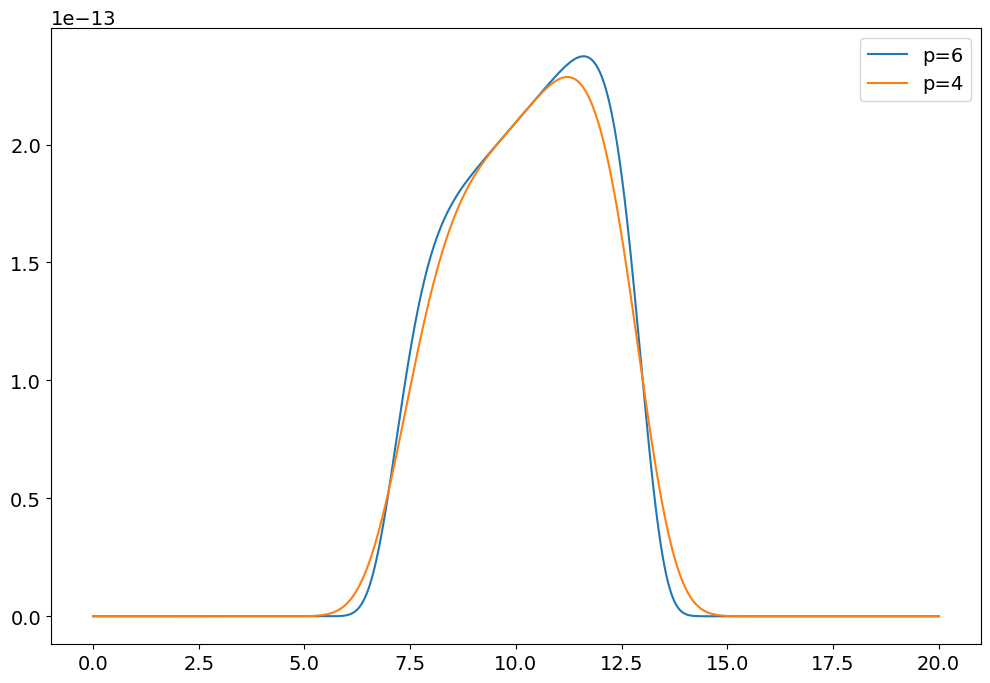

In [13]:
plt.plot(t/tau, gaus_list_6, label="p=6")
plt.plot(t/tau, gaus_list_4, label="p=4")
plt.legend()


In [21]:
def func(x):
    return x**2

In [22]:
from scipy.integrate import quad

In [25]:
x_area = quad(func, 1, 6, limit=1)
print(x_area)

(71.66666666666669, 7.956598343146958e-13)


/tmp/ipykernel_6767/821012922.py:1: IntegrationWarning: The maximum number of subdivisions (1) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  x_area = quad(func, 1, 6, limit=1)


In [27]:
area_4 = quad(supr_gaus_env, 0, las_time, limit=1000, args=(4,))
area_6 = quad(supr_gaus_env, 0, las_time, limit=1000, args=(10,))

print(area_4)
print(area_6)

(3.796729988074018e-27, 3.1135217934950684e-28)
(3.995264749347486e-27, 5.441831567916011e-27)


In [110]:
a0 = 0.5
a0_4 = a0/area_4[0]
a0_6 = a0/area_6[0]
a0_4, a0_6

(116899525297319.14, 102787586370916.16)

In [ ]:
func_area = simps(gaus_list_4, t)

In [99]:
are_4 = simps(gaus_list_4, t)
are_6 = simps(gaus_list_6, t)

In [100]:
are_4, are_6

(1.3877787807814457e-17, -1.3877787807814457e-17)

FFT of the envelope

In [9]:
# Want to resolve frequecy
f0 = omega0/(2*np.pi)
f0,omega0

(300000000000000.0, 1884955592153876.0)

Want to resolve frequecy 

omega0 = 1884955592153876.0

f0 = omega0/(2*np.pi) 

f0 = 300000000000000.0

min sample frequency = 2*f0 = 600000000000000.0

dt_max = 1/2*f0 = 1.6666666666666667e-15

our dt must be less than dt_max while fourier transformation for resolution of frequency omega0
dt = 6.666666666666667e-17



In [10]:
dt_max = 1/(2*f0)
dt_max

1.6666666666666666e-15

In [11]:
dt = t_max/samples
f_max = 1/dt
f = np.linspace(-f_max/2, f_max/2, samples)
omega_fft = 2*np.pi*f

In [12]:
gaus_fft = np.fft.fftshift(np.fft.fft(gaus_list))

(0.0, 5.0)

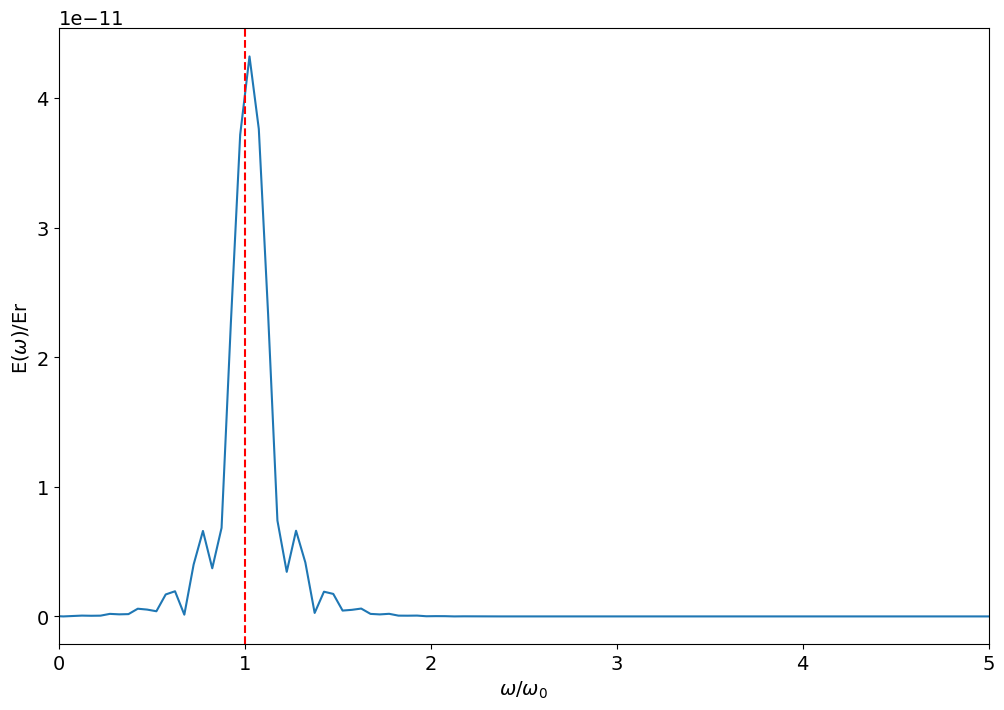

In [13]:
plt.plot(omega_fft/omega0, np.abs(gaus_fft)/Er)
plt.xlabel(r'$\omega/\omega_0$')
plt.ylabel('E($\omega$)/Er')
plt.axvline(x=1, color='r', linestyle='--')
plt.xlim(0, 5)

(0.0, 5.0)

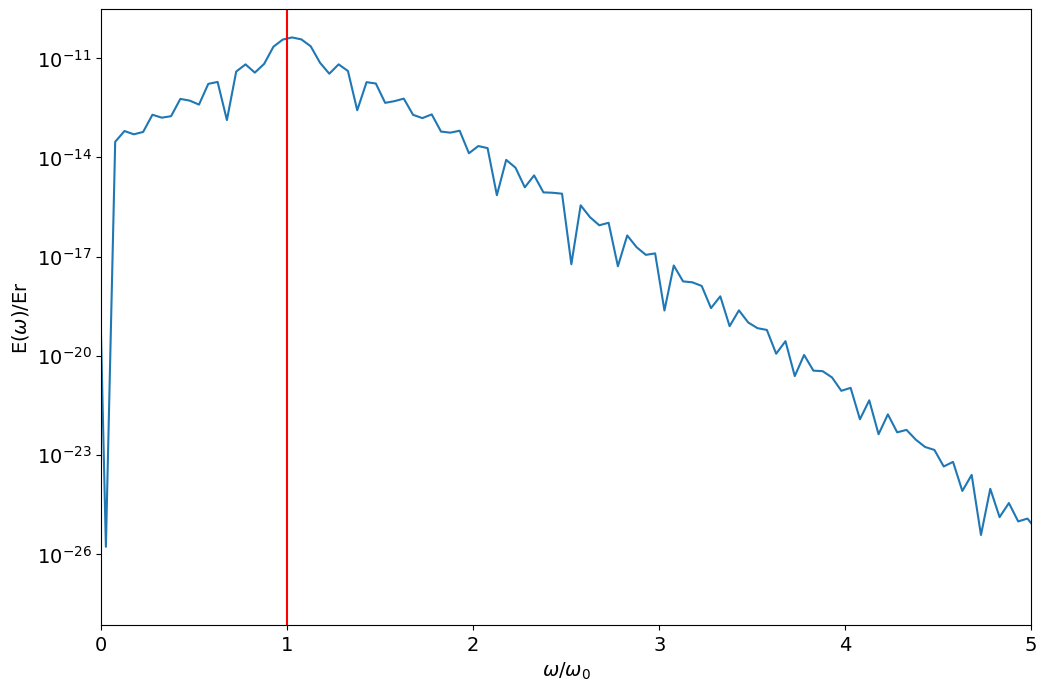

In [14]:
from matplotlib.lines import lineStyles


plt.plot(omega_fft/omega0, np.abs(gaus_fft)/Er)
plt.xlabel(r'$\omega/\omega_0$')
plt.ylabel('E($\omega$)/Er')
plt.yscale('log')
plt.axvline(1,color='r')
plt.xlim(0, 5)

## Simulation

The maximum time step for resolution of the frequency must be 

In [15]:
omega_to_resolve = 20*omega0
f_to_resolve = omega_to_resolve/(2*np.pi)
min_sampling_freq = 2*f_to_resolve
dt_max_to_resolve = 1/(min_sampling_freq)
print(f"The maximum time step for resolution is {dt_max_to_resolve*1e15: .3f} femto seconds")

The maximum time step for resolution is  0.083 femto seconds


so we take 

dt_snapshot = 0.08 femto seconds

so for fft

f_max = 1/dt_snapshot = 12.5 GHz

omega_max = 2*np.pi*f_max = 78.53981633974483

In [16]:
files = glob.glob('../Diff_laser_env/SG/p_4/*.sdf')
files.sort()
len(files)

1669

In [17]:
# data at time  = 100*dt_snapshot=8e-15 
all_data=sdf.read(files[100])
all_data.Electric_Field_Ey.data.shape

(16000,)

In [18]:
den = all_data.Derived_Number_Density_Electron.data

### Density Plot

Text(0, 0.5, 'n/n$_c$')

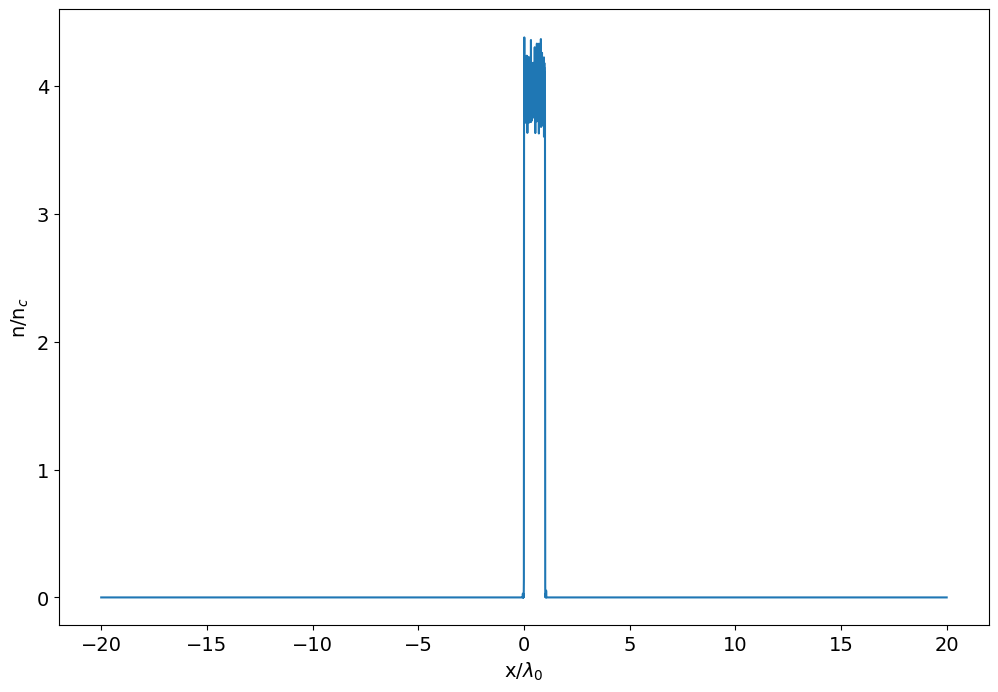

In [19]:
x = np.linspace(x_min, x_max, nx)
t = np.linspace(0, t_end, len(files))
plt.plot(x/lambda0,den/nc)
plt.xlabel('x/$\lambda_0$')
plt.ylabel('n/n$_c$')
# plt.figure(figsize=(12,10))

field at node 0,4000,8000,10000

In [20]:
Ey_0=[]
Ey_4000=[]
Ey_8000=[]
Ey_10000=[]
for f in tqdm.tqdm(files,desc='Reading files'):
    E=sdf.read(f).Electric_Field_Ey.data

    # Ey_0.append(E[0])
    # Ey_4000.append(E[4000])
    Ey_8000.append(E[8000])
    # Ey_10000.append(E[10000])
    


Reading files: 100%|██████████| 1669/1669 [00:40<00:00, 41.64it/s]


In [21]:
# Ey_0 = np.array(Ey_0)
# Ey_4000 = np.array(Ey_4000)
Ey_8000 = np.array(Ey_8000)
# Ey_10000 = np.array(Ey_10000)

In [44]:
las_time = las_time/tau

In [68]:
def supr_gaus_env(t,p):
    if t<0:
        return 0
    elif t<las_time:
        n=(t-0.5*las_time)**p
        d = (0.25*las_time)**p
        a  = np.sin(2*np.pi*t)
        return a*np.exp(-(n/d))
    else:
        return 0

In [69]:
T = np.arange(0, t_end, dt_snapshot)/tau
T.max()

39.98400000000001

In [77]:
pulse = [supr_gaus_env(time-20, p=6) for time in T]

Text(0.5, 1.0, 'Ey at 8000th Node')

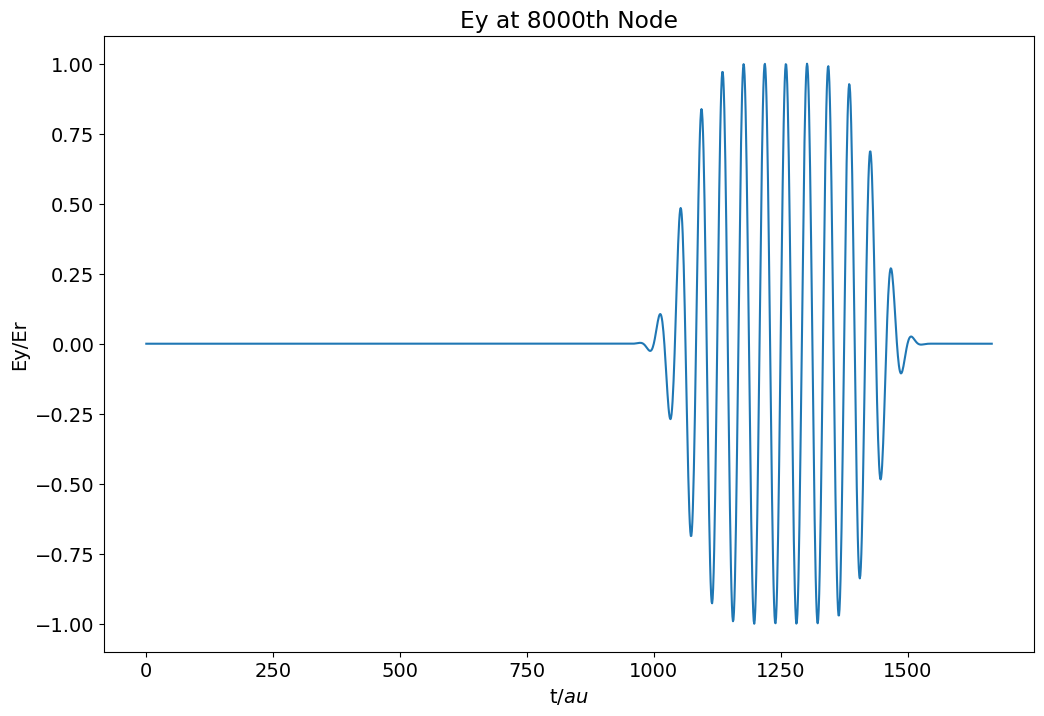

In [78]:
plt.plot(pulse)
plt.xlabel('t/$\tau$')
plt.ylabel('Ey/Er')
plt.title('Ey at 8000th Node')

Text(0.5, 1.0, 'Ey at 8000th Node')

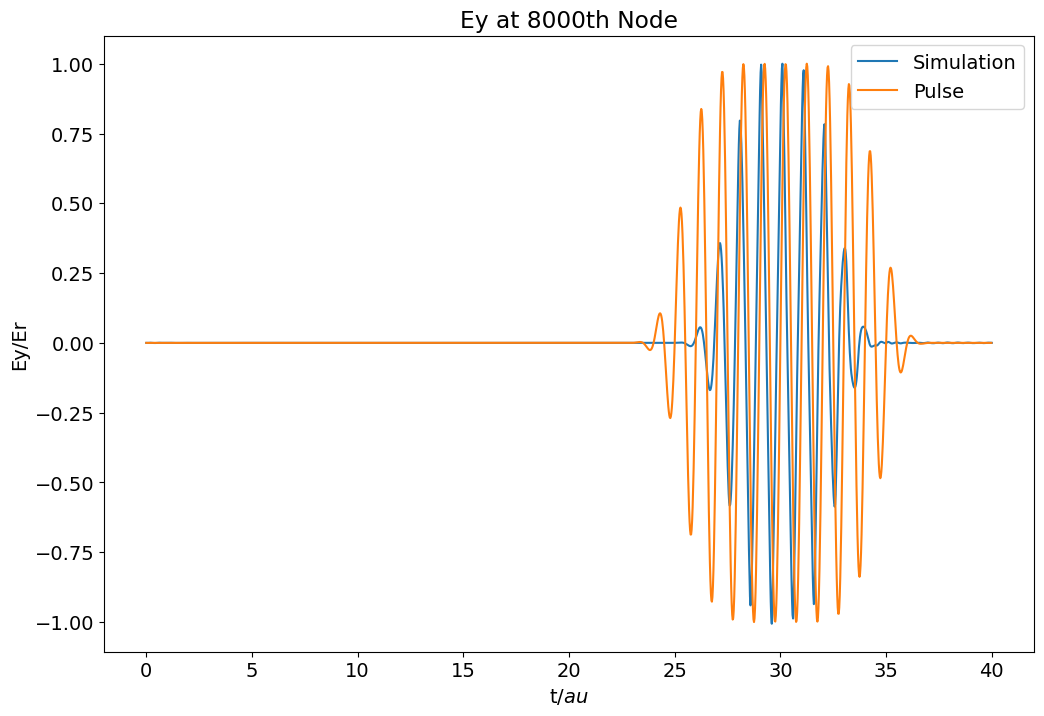

In [79]:
plt.plot(t/tau, Ey_8000/max(Ey_8000), label='Simulation')
plt.plot(T, pulse/max(pulse), label='Pulse')
plt.xlabel('t/$\tau$')
plt.ylabel('Ey/Er')
plt.legend()
plt.title('Ey at 8000th Node')

Text(0.5, 1.0, 'Ey at 8000th Node')

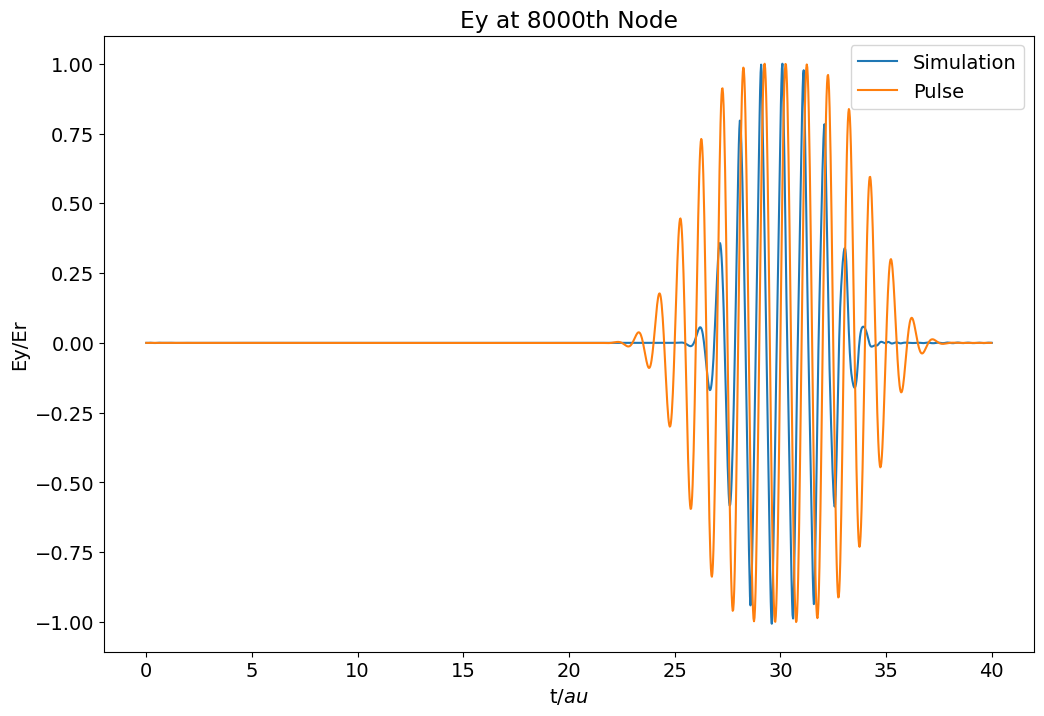

In [76]:
plt.plot(t/tau, Ey_8000/max(Ey_8000), label='Simulation')
plt.plot(T, pulse/max(pulse), label='Pulse')
plt.xlabel('t/$\tau$')
plt.ylabel('Ey/Er')
plt.legend()
plt.title('Ey at 8000th Node')

## FFT

In [21]:
f_max = 1/dt_snapshot
samples = len(files)
f = np.linspace(-f_max/2, f_max/2, samples)
omega_fft = 2*np.pi*f


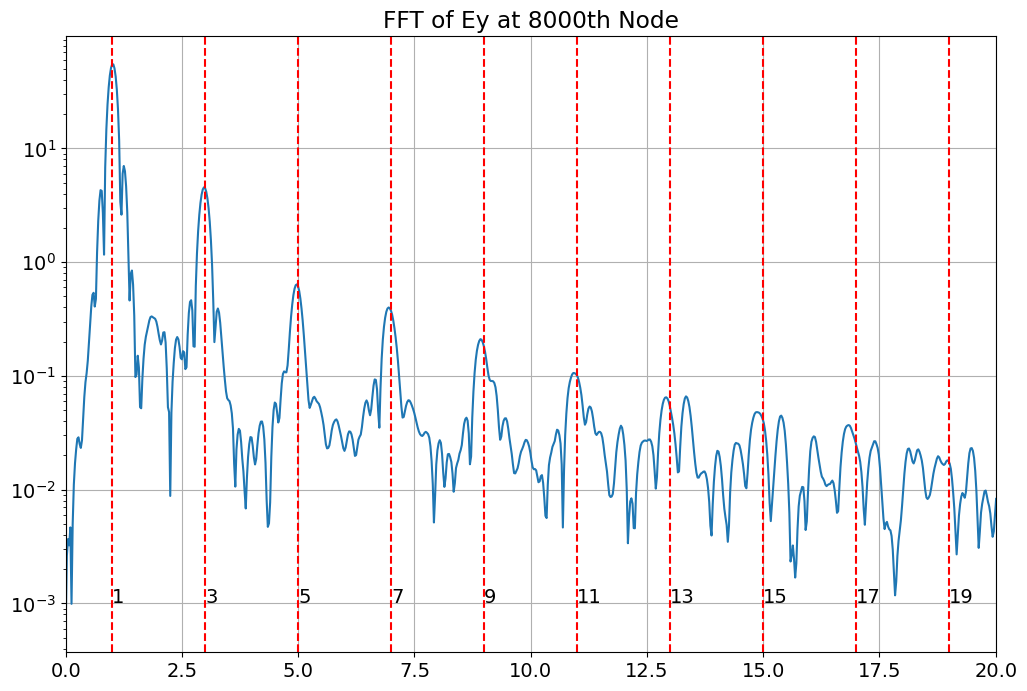

In [22]:
Ey_8000_fft = np.fft.fft(Ey_8000)
Ey_8000_fft = np.fft.fftshift(Ey_8000_fft)
# plt.figure(dpi=300)
plt.plot(omega_fft/omega0, np.abs(Ey_8000_fft)/Er)
plt.xlim(0,20)
plt.title('FFT of Ey at 8000th Node')
plt.yscale("log")
plt.grid()
for i in range(1,20,2):
    plt.axvline(i, color='r', linestyle='--')
    plt.annotate(f"{i}",  (i, 1e-3),color='black')
plt.show()

In [23]:
len(files)
print("len(files): ",len(files))
arr = np.zeros((len(files),16000))
arr = np.zeros((len(files),16000))
for t in range(0,len(files)):
    arr[t]=sdf.read(files[t]).Derived_Number_Density_Electron.data

print('arr.shape:',arr.shape)


len(files):  1669
arr.shape: (1669, 16000)


In [24]:
EXTENT = [-20, 20, 40, 0]

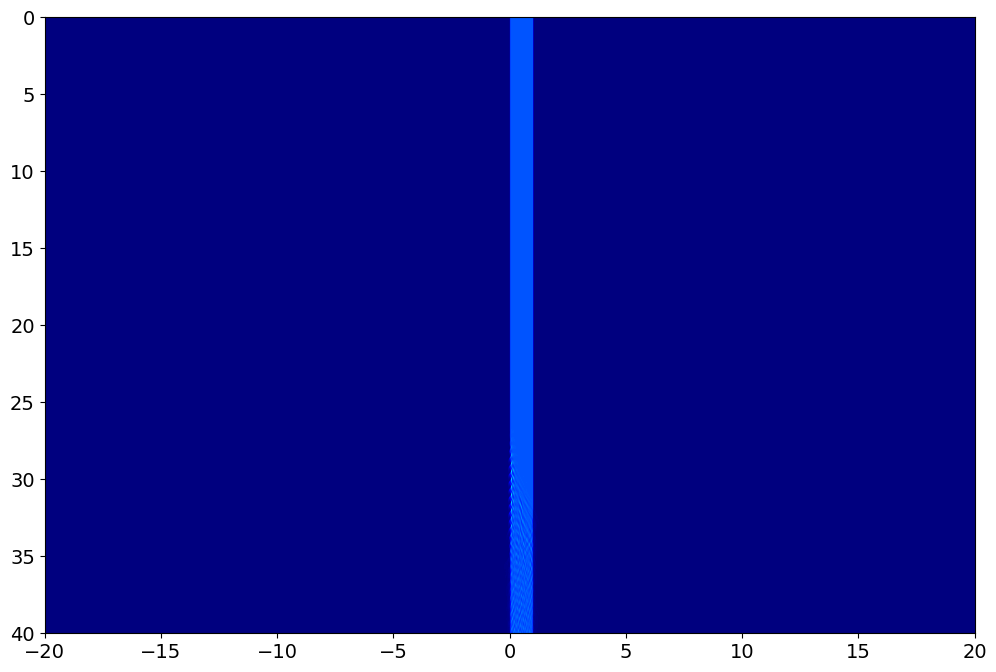

In [25]:
plt.imshow(arr[:, :], extent=EXTENT, aspect="auto", cmap="jet")
# plt.colorbar()

Data is not loaded. Loading data...


Loading Data...: 100%|██████████| 417/417 [00:04<00:00, 92.69it/s] 


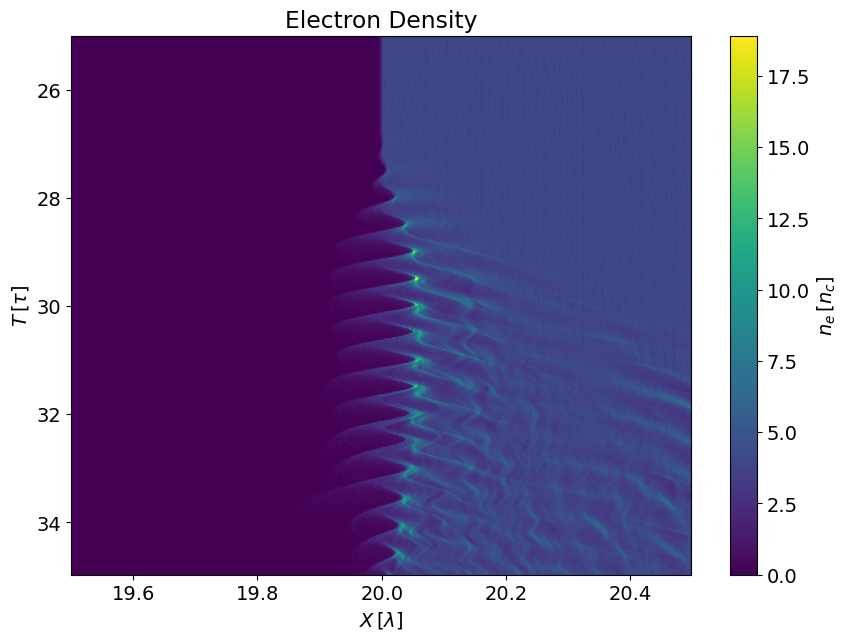

In [7]:

time_range =(25, 35)
space_range = (19.5, 20.5)
space_are_nodes = False
time_are_nodes = False
fig, ax = ez.plot_density_image(
    normalize=True,
    time_range=time_range,
    space_range=space_range,
    space_are_nodes=space_are_nodes,
    times_are_nodes=time_are_nodes,
    show_fig=True,
    aspect="auto",

)

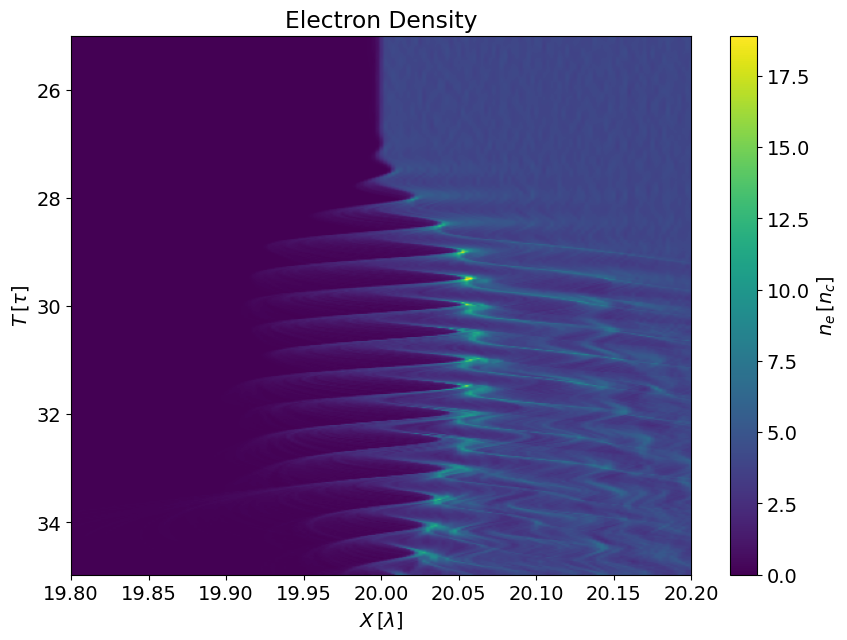

In [8]:
ax.set_xlim(19.8, 20.2)
fig